# SARIMA 

In [1]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from concurrent.futures import ProcessPoolExecutor
from loky import get_reusable_executor
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd

from itertools import product
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Wetter Daten

In [2]:
# Daten
data = pd.read_csv('../data/processed_weather_data_monthly.csv')
data.head()

,Date_Time,p_(mbar),T_(degC),Tpot_(K),Tdew_(degC),rh_(%),VPmax_(mbar),VPact_(mbar),VPdef_(mbar),sh_(g/kg),...,Wy,max_Wx,max_Wy,day_of_month,day_of_year,month,week_of_year,year,p_(mbar)_lag_1,T_(degC)_lag_1
0,2009-01-31,988.982786,-3.608829,270.427954,-5.886043,84.912571,5.007564,4.197254,0.810565,2.652463,...,0.025590,-1.213489,0.064542,0.516780,0.043891,0.083333,0.059092,-2009.0,947.711588,-3.440148
1,2009-02-28,985.634256,0.172842,274.476741,-2.187976,84.699048,6.353140,5.352143,1.001280,3.387649,...,-0.840575,-0.914875,-1.499944,0.467742,0.124658,0.166667,0.138814,-2009.0,944.562068,0.179196
2,2009-03-31,986.120551,3.985013,278.262352,0.359301,78.513091,8.284704,6.393078,1.891680,4.045914,...,-1.165809,-1.432551,-2.008539,0.516129,0.205479,0.250000,0.218503,-2009.0,945.020578,3.856210
3,2009-04-30,987.524597,11.876306,286.066583,5.735306,69.199778,14.628014,9.312458,5.315736,5.890417,...,0.345908,0.391256,0.604917,0.500000,0.289041,0.333333,0.300629,-2009.0,946.369931,11.434250
4,2009-05-31,992.100565,13.434731,287.248790,7.819059,70.969772,16.045927,10.835565,5.209933,6.826344,...,-0.291017,-0.076733,-0.510291,0.516129,0.372603,0.416667,0.382228,-2009.0,950.754597,12.943992


In [3]:
# Datengröße
data.shape

(96, 23)

In [4]:
# Datenauswahl,SARIMA nimmt nur eine Eingabe + Exog-Variable und gibt nur eine Ausgabe aus.
# Hier T (degC) für Temperatur
in_str= "T_(degC)"
exog_str = "day_of_month"
temp_data = data[["Date_Time", in_str, exog_str]]
temp_data.shape

(96, 3)

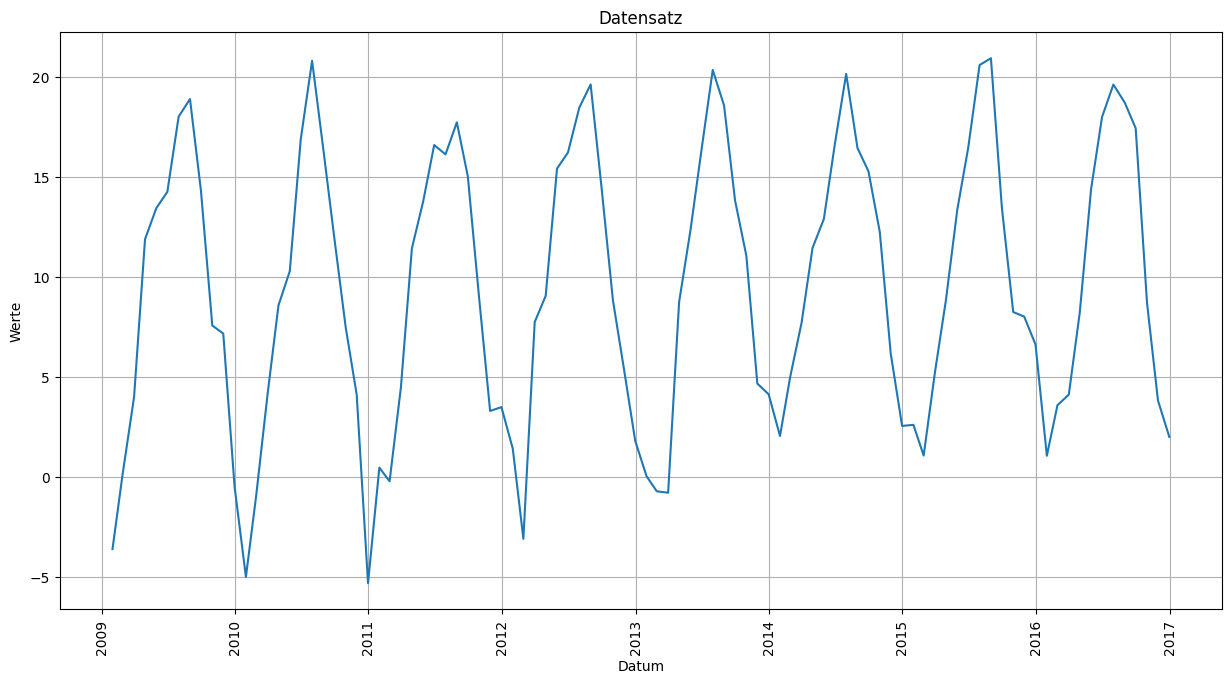

In [5]:
# Datensatz visualisieren und Stationarität bestätigen
plt.figure(figsize=[15, 7.5]); 
date = pd.to_datetime(temp_data["Date_Time"], format="%Y-%m-%d")
plt.plot(date, temp_data[in_str])
plt.title('Datensatz')
plt.ylabel('Werte')
plt.xlabel('Datum')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

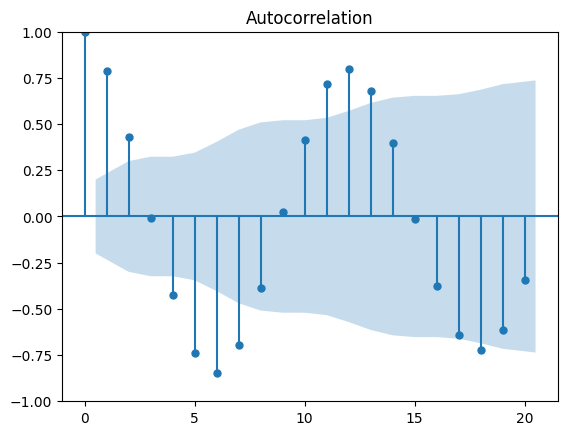

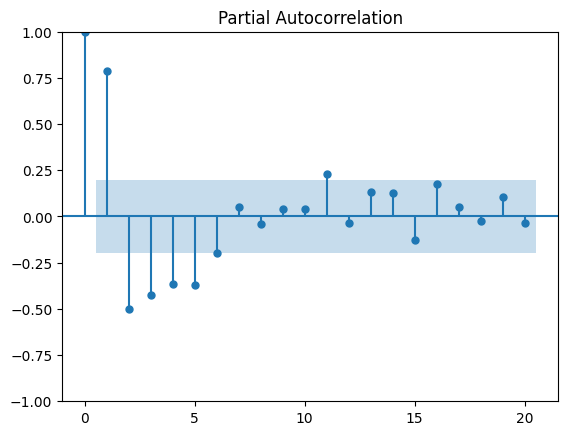

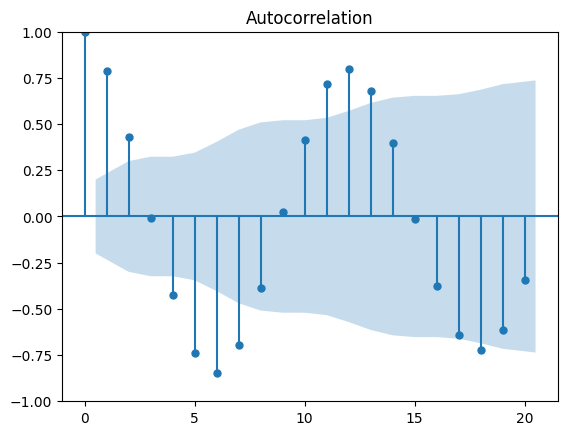

In [6]:
#Das Model benötigt folgende 3 Werte (d,D,s): 
#   - d - Integrationsordnung: Differenzierung bis daten stationär sind.
#   - D - saisonale Integrationsordnung: Differenzierung bis Daten Stationär sind.
#   - s - Länge der Saison: Eine Seasonalität kann sich durch die Periodizität der Welle im Acf bestimmen. 

plot_pacf(temp_data[in_str])
plot_acf(temp_data[in_str])

In [7]:
# Da die PAcf und Acf keine konkreten Daten geben, wird der Dickey-Fuller-test angewendet
# Augmented Dickey-Fuller test: Präsenz von Einheitswurzeln im Datensatz

ad_fuller_result = adfuller(temp_data[in_str])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -1.3617199450902167
p-value: 0.6004843404349731


In [8]:
def train_val_test_split(data, train_ratio=0.7, val_ratio=0.15):
    train_size = int(len(data) * train_ratio)
    val_size = int(len(data) * val_ratio)
    train_data = data[:train_size]
    val_data = data[train_size:train_size+val_size]
    test_data = data[train_size+val_size:]
    return train_data, val_data, test_data


def train_sarimax(train_data, order, seasonal_order):
    return SARIMAX(train_data, order=order, seasonal_order=seasonal_order).fit(dis=-1)

def evaluate_model(model, test_data):
    predictions = model.forecast(steps=len(test_data))
    mae = mean_absolute_error(test_data, predictions)
    return mae

In [9]:
#Das sehr niedrige p-Wert zeigt an, dass die Nullhypothese der Nicht-Stationarität abgelehnt werden kann. Die ADF-Statistik ist ausreichend negativ, was darauf hinweist, dass die Zeitreihe nach der saisonalen Differenzierung bei einer Periode von 12 Monaten stationär ist

# Nun wird der differnenzierte Datensatz für die weiteren Vorgänge verwendet
diff_data = temp_data # Nur um die Übersicht zu behalten

In [10]:
train_data, val_data, test_data = train_val_test_split(diff_data)

In [11]:
def optimize_SARIMA(parameters_list, d, D, s, train, exog, exog_future, val_data=None):
    """
        Rückgabe des DataFrame mit Parametern, entsprechenden AIC (relative Qualität statistischer Modelle) und SSE (Differenzen zwischen beobachteten und vorhergesagten Werten).#
        Desto kleiner der AIC und SSE-Wert, desto besser das Model.
        
        
        
        parameters_list - Liste mit Tupeln (p, q, P, Q)
        d - Integrationsordnung
        D - saisonale Integrationsordnung
        s - Länge der Saison
        train - die Trainingsdaten
        exog - die exogene Variable
        exog_future - die exogenen Validierungsdaten
        val_data - die Validierungsdaten
    """
    results = []

    train_df = train.to_frame('train_column_name')
    exog_df = exog.to_frame('exog_column_name')   

    if not train_df.index.equals(exog_df.index):
        # Synchronisierung der Indizes
        combined = train_df.join(exog_df, how='inner')  # Dies führt zu einem DataFrame, bei dem nur übereinstimmende Indizes behalten werden

        # Trennung der synchronisierten Daten zurück in endogen und exogen
        train_synced = combined[train_df.columns]
        exog_synced = combined[exog_df.columns]
    else:
        # Wenn die Indizes bereits übereinstimmen
        train_synced = train_df
        exog_synced = exog_df

    for param in tqdm_notebook(parameters_list):
            
       
        try: 
            model = SARIMAX(endog=train_synced, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s), exog=exog_synced).fit(disp=-1)
            aic = model.aic

            # Berechnung des MAE, wenn val_data bereitgestellt wird
            if val_data is not None:
                predictions = model.get_prediction(start=len(train_synced), end=len(train_synced)+len(val_data)-1, exog=exog_future)
                prediction_summary = predictions.summary_frame()
                mae = mean_absolute_error(val_data, prediction_summary['mean'])
                results.append([param, aic, mae])
            else:
                results.append([param, aic])

        except:
            continue
            
    result_df = pd.DataFrame(results)
    print(result_df)
    if val_data is not None:
        result_df.columns = ['(p,q)x(P,Q)', 'AIC', 'MAE']
    else:
        result_df.columns = ['(p,q)x(P,Q)', 'AIC']

    # Sortieren nach AIC (aufsteigend)
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [12]:
# Sowohl die saisonalen als auch die nicht-saisonalen Integrationsparameter sind jeweils 1 , und die Länge der Saison beträgt 12.
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 12

parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [13]:
result_df = optimize_SARIMA(parameters_list, d, D, s, train_data[in_str],train_data[exog_str], val_data[exog_str], val_data[in_str])
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

                0           1         2
0    (0, 0, 0, 0)  298.963952  1.542710
1    (0, 0, 0, 1)  279.230719  2.070187
2    (0, 0, 0, 2)  280.870078  2.094936
3    (0, 0, 0, 3)  282.144248  1.816063
4    (0, 0, 1, 0)  280.636649  1.299500
..            ...         ...       ...
251  (3, 3, 2, 3)  269.409363  1.547416
252  (3, 3, 3, 0)  265.681370  1.641438
253  (3, 3, 3, 1)  267.658991  1.596741
254  (3, 3, 3, 2)  269.799715  1.456074
255  (3, 3, 3, 3)  271.685954  1.444936

[256 rows x 3 columns]


,"(p,q)x(P,Q)",AIC,MAE
0,"(0, 1, 0, 1)",260.184117,1.626606
1,"(1, 1, 0, 1)",261.158558,1.525086
2,"(0, 1, 0, 2)",261.365734,1.392123
3,"(0, 1, 1, 1)",261.396057,1.410604
4,"(0, 1, 2, 0)",261.410584,1.403531
...,...,...,...
251,"(0, 0, 3, 2)",284.836203,2.330574
252,"(0, 0, 2, 3)",285.335491,1.602350
253,"(0, 0, 3, 3)",286.439957,2.369271
254,"(1, 0, 0, 0)",288.405184,1.552811


In [14]:
result_df.sort_values(by='MAE', ascending=True).reset_index(drop=True)

,"(p,q)x(P,Q)",AIC,MAE
0,"(2, 0, 1, 0)",268.201843,1.137754
1,"(3, 0, 2, 0)",268.714455,1.140766
2,"(3, 0, 2, 2)",272.615226,1.153262
3,"(3, 0, 1, 0)",269.257038,1.155938
4,"(3, 0, 3, 0)",270.746347,1.160505
...,...,...,...
251,"(1, 2, 0, 0)",279.000342,2.411579
252,"(1, 1, 0, 0)",280.460508,2.470470
253,"(0, 2, 0, 0)",280.454700,2.472328
254,"(0, 1, 0, 0)",278.518187,2.472529


In [22]:
# Best model ist ARIMA 0,2,3,0) AIC=256
# Das SARIMAX ist eine erweiterung des SARIMA's. Diese lässt zusätzliche Variablen von außen zu. zB könnte diese die Tageszeiten beinhalten, welche Einfluss auf die Wetterbedingungen haben könnte.
# order=(p,d,q) => p=0, d=1, q=2
# seasonal_order=(P,D,Q,s) => P=3, D=1, Q=0, s=12
best_model = SARIMAX(diff_data[in_str], exog=diff_data[exog_str], order=(2, 1, 0), seasonal_order=(1,1,0,12)).fit(dis=-1)
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           T_(degC)   No. Observations:                   96
Model:             SARIMAX(2, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -198.619
Date:                            Mon, 19 Feb 2024   AIC                            407.239
Time:                                    15:19:16   BIC                            419.333
Sample:                                         0   HQIC                           412.097
                                             - 96                                         
Covariance Type:                              opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
day_of_month   -79.6804     33.451     -2.382      0.017    -145.243     -14.117
ar.L1           -0.6277      

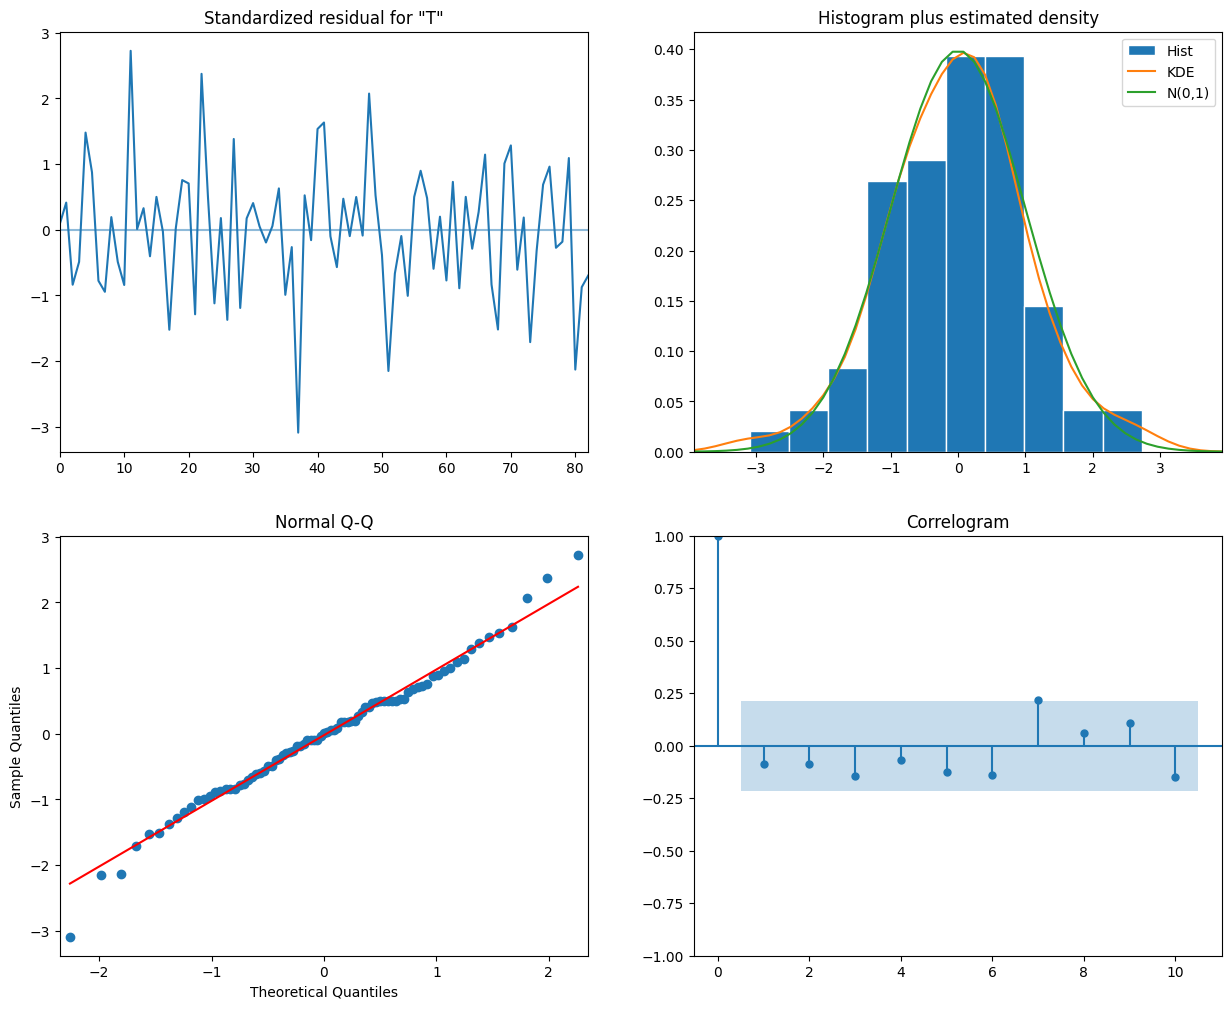

In [23]:
best_model.plot_diagnostics(figsize=(15,12));

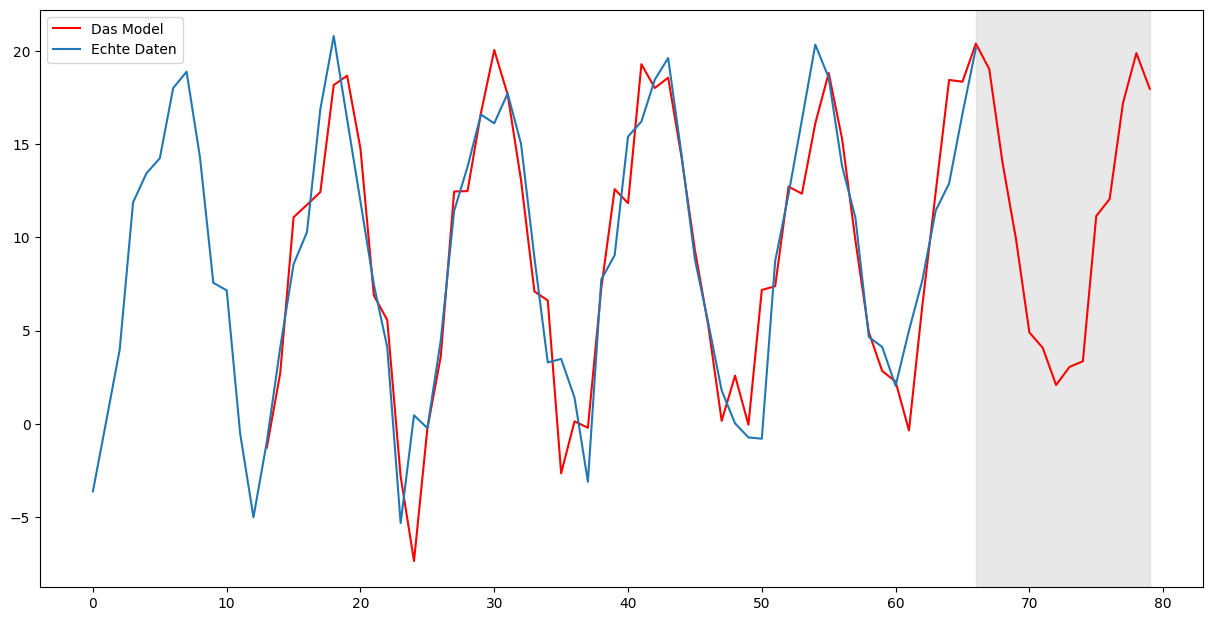

In [24]:
plot_data = train_data

plot_data['arima_model'] = best_model.fittedvalues
plot_data['arima_model'][:12+1] = np.NaN

forecast = best_model.predict(start=plot_data.shape[0], end=plot_data.shape[0] + 12)
forecast = plot_data['arima_model']._append(forecast)

plt.figure(figsize=(15, 7.5))
plt.plot(forecast[-150:], color='r', label='Das Model')
plt.axvspan(plot_data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(plot_data[in_str][-150:], label='Echte Daten')
plt.legend()

plt.show()

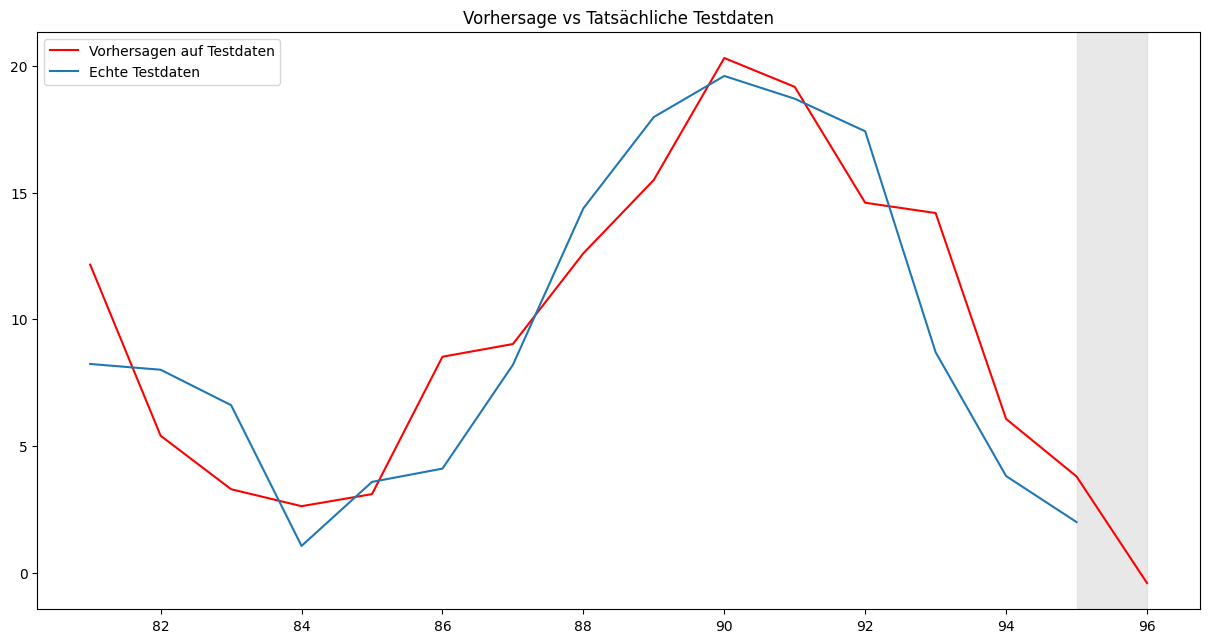

In [25]:
# TEST_DATA

test_forecast = best_model.predict(start=train_data.shape[0]+val_data.shape[0], end=train_data.shape[0]+val_data.shape[0] + test_data.shape[0], exog=test_data[exog_str][-2:-1])

# Visualisierung der Vorhersagen für die Testdaten
plt.figure(figsize=(15, 7.5))
plt.plot(test_forecast[-150:], color='r', label='Vorhersagen auf Testdaten')
plt.axvspan(test_data.index[-1], test_forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(test_data[in_str][-150:], label='Echte Testdaten')

plt.legend()
plt.title('Vorhersage vs Tatsächliche Testdaten')
plt.show() 

In [26]:
from sklearn.metrics import mean_absolute_error

# Berechnung des MAE
mae = mean_absolute_error(test_data[in_str], test_forecast[:-1])
mae

2.329059907197964

In [27]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_data[in_str], test_forecast[:-1])
mse

7.502703727380044

In [28]:
def smape_loss(y_pred, target):
    loss = 2 * (y_pred - target).abs() / (y_pred.abs() + target.abs() + 1e-8)
    return loss.mean()
smape = smape_loss(test_data[in_str], test_forecast[:-1])
smape

0.3538320056784607